# Fitting Thomson Scattering Spectra

Thomson scattering diagnostics record a scattered power spectrum that encodes information about the electron and ion density, temperatures, and flow velocities. This information can be retreived by fitting the measured spectrum with the theoretical spectral density (`thomson.spectral_density`). This notebook demonstrates how to use the `lmfit` package (along with some helpful PlasmaPy functions) to fit 1D Thomson scattering spectra. 


* Put a figure here showing an example of collective vs. non-collective scattering. *

Thomson scattering can be either non-collective (dominated by single electron scattering) or collective (dominated by scattering off of electron plasma waves (EPW) and ion acoustic waves (IAW). In the non-collective regime, the scattering spectrum contains a single peak. However, in the collective regime the spectrum contains separate features caused by the electron and ion populations (corresponding to separate scattering off of EPW and IAW). These features exist on different scales: the EPW feature is dim but covers a wide wavelength range, while the IAW feature is bright but narrow. They also encode partially-degenerate information (eg. the flow velocities of the electrons and ions respectively). The two features are therefore often recorded on separate spectrometers and are fit separately. 


In [27]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

import corner

from lmfit import Parameters
from plasmapy.diagnostics import thomson

## Example: Fitting Spectra in the Collective Regime

To demonstrate the fitting capabilities, we'll first generate some synthetic Thomson data using `thomson.spectral_density`. This data will be in the collective regime, so we will generate two datasets (using the same plasma parameters and probe geometry) that correspond to the EPW and IAW features.

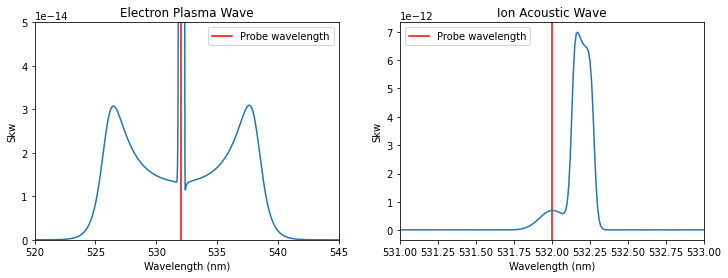

In [2]:
# Generate theoretical spectrum
probe_wavelength = 532*u.nm
epw_wavelengths = np.arange(probe_wavelength.value-60, probe_wavelength.value+60, 0.01)*u.nm
iaw_wavelengths = np.arange(probe_wavelength.value-3, probe_wavelength.value+3, 0.01)*u.nm

probe_vec = np.array([1, 0, 0])
scattering_angle = np.deg2rad(63)
scatter_vec = np.array([np.cos(scattering_angle), np.sin(scattering_angle), 0])

n = 2e17*u.cm**-3
ion_species = ['H+', 'C-12 5+']
Te = 10*u.eV
Ti = np.array([20, 50]) * u.eV
electron_vel = np.array([[0, 0, 0]])*u.km/u.s
ion_vel =  np.array([[0, 0, 0], [200, 0, 0]])*u.km/u.s
ifract = [0.3, 0.7]

alpha, epw_skw = thomson.spectral_density(epw_wavelengths, probe_wavelength,
                     n, Te, Ti, ion_species=ion_species,
                     ifract=ifract,
                     electron_vel=electron_vel,ion_vel=ion_vel,
                     probe_vec=probe_vec, scatter_vec=scatter_vec)

alpha, iaw_skw = thomson.spectral_density(iaw_wavelengths, probe_wavelength,
                     n, Te, Ti, ion_species=ion_species,
                     ifract=ifract,
                     electron_vel=electron_vel,ion_vel=ion_vel,
                     probe_vec=probe_vec, scatter_vec=scatter_vec)

# PLOTTING
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax[0].set_xlim(520, 545)
ax[0].set_ylim(0, 5e-14)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(531, 533)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend()

Next we'll add some noise to the spectra to simulate an experimental measurement.

During experiments, the IAW feature is typically blocked on the EPW detector using a notch filter to prevent it from saturating the measurement. We'll mimic this by setting the center of the EPW spectrum to `np.nan`. The fitting algorithm applied later will recognize these values and not include them in the fit.

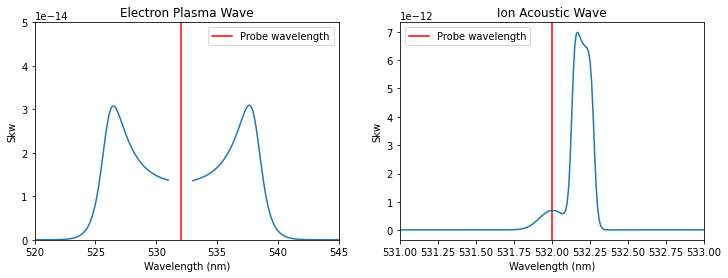

In [3]:
notch_range = (531, 533)
x0 = np.argmin(np.abs(epw_wavelengths.value - notch_range[0]))
x1 = np.argmin(np.abs(epw_wavelengths.value - notch_range[1]))
epw_skw[x0:x1] = np.nan


# Add noise to both signals
#epw_skw +=  (np.random.rand(epw_wavelengths.size)-0.5)*np.max(np.nan_to_num(epw_skw,0))*0.01
#iaw_skw +=  (np.random.rand(iaw_wavelengths.size)-0.5)*np.max(iaw_skw)*0.01

# Plot again
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax[0].set_xlim(520, 545)
ax[0].set_ylim(0, 5e-14)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(531, 533)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend()

We'll start by fitting the EPW feature, then move on to the IAW feature. This is typically the process followed when analyzing experimental data, since the IAW feature depends on fewer parameters.

### Fitting the EPW Feature

In order to fit this data in `lmfit`, we need to define a [`lmfit.Parameters`](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters) object, which is an ordered dictionary of [`lmfit.Parameter`](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) objects. Each `Parameter` has a number of elements, the most important of which for our purposes are
- "name" (str) -> The name of the parameter (and the key in `Parameters` dictionary)
- "value" (float) -> The initial value of the parameter.
- "vary" (boolean) -> Whether or not the parameter will be varied during fitting.
- "min", "max" (float) -> The minimum and maximum bounds for the parameter during fitting.

Since `Parameter` objects can only be scalars, arrays of multiple quantities must be broken apart into separate `Parameter` objects. To do so, this fitting routine adopts the following convention:

`Te = [1,2] -> "Te_0"=1, "Te_1" = 2`

Specifying large arrays (like velocity vectors for multiple ion species) is clearly tedious in this format, and specifying non-numeric values (such as `ion_species`) is impossible. Therefore, this routine also takes a `settings` dictionary as a way to pass non-varying input to the `thomson.spectral_density` function.

A list of required and optional parameters and settings is provided in the docstring for the model functions. For example, for the EPW-only model function:

In [4]:
help(thomson.epw_model)

Help on function epw_model in module plasmapy.diagnostics.thomson:

epw_model(wavelengths, settings, params)
    Returns a `lmfit` Model function for the EPW feature.
    
    
    Parameters
    ----------
    
    wavelength : 'astropy.units.Quantity' array
        Array of wavelengths over which to to evaluate the model. Units must
        be convertable to nm.
    
    
    settings : dict
        A dictionary of non-variable inputs to the spectral density function
        which must include the following:
    
            - probe_wavelength (`astropy.units.Quantity`):  Probe wavelength, convertable to nm
            - probe_vec (`np.ndarray`, shape (3,)): unit vector in the probe direction
            - scatter_vec: (`np.ndarray`, shape (3,)): unit vector in the scattering direction
    
        and may contain the following optional variables
            - electron_vdir : (e#, 3) array of electron velocity unit vectors
    
        These quantities cannot be varied.
    
    
   

We will now create the `Parameters` object and settings dictionary using the values defined earlier when creating the sample data. We will choose to vary both the density and electron temperature, and will intentionally set the wrong initial values for both parameters. Note that, even though only one electron population is inclued, we must still name the temperature variable `Te_0`

In [5]:
settings = {}
settings['probe_wavelength'] = probe_wavelength
settings['probe_vec'] = probe_vec
settings['scatter_vec'] = scatter_vec

params = Parameters()
params.add('n', value=4e17, vary=True, min=5e16, max=1e18)
params.add('Te_0', value=5, vary=True, min=0.5, max=25)

We can now use these objects to initialize a [`lmfit.Model`](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) object based on the `thomson.spectral_density` function. This process is non-trivial, but PlasmaPy provides a wrapper function that takes care of everything 

In [6]:
model = thomson.epw_model(epw_wavelengths, settings, params)

With the model created, the fit can be easily performed using the [`model.fit`](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model.fit) function. This function takes several keyword options that are worth mentioning: 

- "method" -> A string that defines the fitting method, from the list of options [here](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.minimize)

- "max_nfev" -> The maximum number of iterations allowed.

In addition, of course we also need to include the data to be fit (`epw_skw`), the independent variable (`wavelengths`) and the parameter object. It is important to note that the data to be fit should be a `np.ndarray` (unit-less) and normalized.

In [7]:
# Strip units and normalize the data (ignoring any NaN values)
fit_data = epw_skw.value
fit_data *= 1/np.max(np.nan_to_num(fit_data,0))

result = model.fit(fit_data, params=params, wavelengths=epw_wavelengths,  method='leastsq')

The return from this function is a [`lmfit.ModelResult`](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult) object, which is a convenient package that contains lots of information! To start with, we can see the best-fit parameters, number of iterations, the chiSquared goodness-of-fit metric, and plot the best-fit curve.

Best fit parameters:
{'n': 2.1117323037193286e+17, 'Te_0': 9.365466238598554, 'efract_0': 1.0, 'electron_speed_0': 0.0}
Number of fit iterations:19
Reduced Chisquared:0.0027


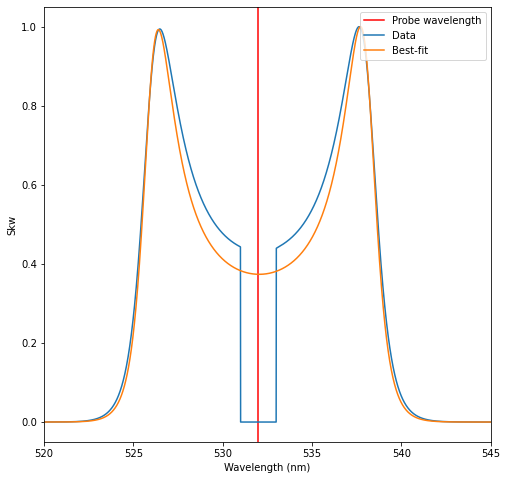

In [8]:

print(f"Best fit parameters:\n{result.best_values}")
print(f"Number of fit iterations:{result.nfev}")
print(f"Reduced Chisquared:{result.redchi:.4f}")

# Extract the best fit curve
best_fit_skw = result.best_fit

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax.set_xlim(520, 545)

ax.plot(epw_wavelengths.value, epw_skw, label='Data')
ax.plot(epw_wavelengths.value, best_fit_skw, label='Best-fit')
ax.legend(loc='upper right')

The resulting fit is very good far from the probe wavelength (where the electron signal is dominant), but not so good closer to the probe wavelength where the influence of the ions is missing. Still, this fit gives us a passable first estimate of the electron parameters, which was the goal!

We can also use the [`ModelResult.conf_interval()`](https://lmfit.github.io/lmfit-py/confidence.html) function to calculate confidence intervals for each of the fitted parameters. Several useful keywords for this function include:
- "sigmas" -> The standard deviations within which to calculate the confidence
- "p_names" -> The key names of the parameters to consider

For example, we can calculate the 3$\sigma$ confidence intervals for the two fitted parameters.

In [9]:
ci = result.conf_interval(sigmas=[2], p_names=['n', 'Te_0'])
print(ci)

OrderedDict([('n', [(0.9544997361036416, 2.103483458156054e+17), (0.0, 2.1117323037193286e+17), (0.9544997361036416, 2.1196001366996976e+17)]), ('Te_0', [(0.9544997361036416, 9.325628035608144), (0.0, 9.365466238598554), (0.9544997361036416, 9.404812434550031)])])


Each entry in this `OrderedDict` contains the values at $-3\sigma$, the best fit value, and $+3\sigma$. These values are extracted as follows

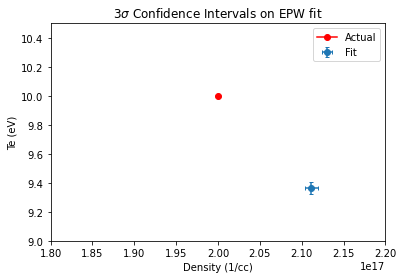

In [10]:
nm3 = ci['n'][0][1]
n_fit = ci['n'][1][1]
np3 = ci['n'][2][1]

Tem3 = ci['Te_0'][0][1]
Te_0_fit = ci['Te_0'][1][1]
Tep3 = ci['Te_0'][2][1]

# Format the errorbars for input to matplotlib.errorbar
yerr  = np.array([[Te_0_fit-Tem3], [Tep3-Te_0_fit]])
xerr = np.array([[n_fit-nm3], [np3-n_fit]])


fig, ax = plt.subplots()
ax.set_title("3$\sigma$ Confidence Intervals on EPW fit")
ax.set_xlabel("Density (1/cc)")
ax.set_ylabel("Te (eV)")

ax.set_xlim(1.8e17, 2.2e17)
ax.set_ylim(9, 10.5)
ax.plot(n.value, Te.value, marker='o', color='red', label='Actual')
ax.errorbar(n_fit, Te_0_fit, yerr=yerr, xerr=xerr, fmt='o', capsize=2, label='Fit')
ax.legend()

Note that these values are incorrect! This is because the data is not well-fit by the EPW model alone (since the ions are having a substantial effect near the probe wavelength). At the end of this document we will return to fitting the EPW feature using the full `thomson.thomson_model` model and show how that model reproduces the correct values.

## Fitting the IAW feature

We will now follow the same steps to fit the IAW feature, but using the `thomson.thomson_model` model function instead of the EPW one. There is no `iaw_model` function, because the IAW data technically includes the EPW scattering as well. However, since the IAW feature is much brighter, fitting this data is much less sensitive to the electron parameters. The normal process is therefore to extract electron paramters from the EPW feature, then apply those as fixed parameters to the IAW data.

In [11]:
settings = {}
settings['probe_wavelength'] = probe_wavelength
settings['probe_vec'] = probe_vec
settings['scatter_vec'] = scatter_vec
settings['ion_species'] = ion_species
settings['ion_vdir'] = np.array([[0, 0, 0], [1, 0, 0]])

params = Parameters()
params.add('n', value=n_fit, vary=False)
params.add('Te_0', value=Te_0_fit, vary=False)
params.add('Ti_0', value=10, vary=True, min=5, max=60)
params.add('Ti_1', value=10, vary=True, min=5, max=60)
params.add('ifract_0', value=0.5, vary=True, min=0.2, max=0.8)
params.add('ifract_1', value=0.5, vary=True, min=0.2, max=0.8, expr='1.0 - ifract_0')
params.add('ion_speed_0', value=0, vary=False)
params.add('ion_speed_1', value=0, vary=True, min=0, max=1e6)

Note here the appearance of the `ion_species` and `ion_vdir` keys in the `settings` dictionary, as well as ion parameters in the `Paramters` object. 

`lmfit` allows the value of a parameter to be fixed using a [constraint](https://lmfit.github.io/lmfit-py/constraints.html) using the `expr` keyword as shown in the definition of `ifract_1` above. In this case, `ifract_1` is not actually a free parameter, since its value is fixed by the fact that `ifract_0 + ifract_1 = 1.0`. This constraint is made explicit here, but the `thomson.thomson_model` and `thomson.epw_model` functions will automatically enforce this constraint for `efract` and `ifract` variables.

Best fit parameters:
{'n': 2.1117323037193286e+17, 'Te_0': 9.365466238598554, 'Ti_0': 19.14764236040977, 'Ti_1': 51.263252422507044, 'ifract_0': 0.29937369700757477, 'ifract_1': 0.7006263029924252, 'ion_speed_0': 0, 'ion_speed_1': 199822.79939824255, 'efract_0': 1.0, 'electron_speed_0': 0.0}
Number of fit iterations:2060
Reduced Chisquared:0.0000


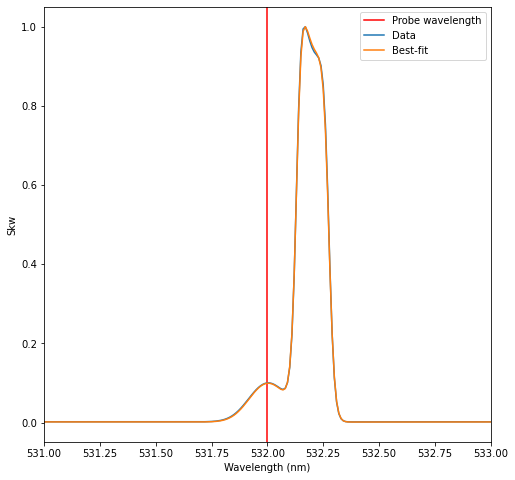

In [12]:
model = thomson.thomson_model(iaw_wavelengths, settings, params)

# Strip units and normalize the data (ignoring any NaN values)
fit_data = iaw_skw.value
fit_data *= 1/np.max(fit_data)

result = model.fit(fit_data, params=params, wavelengths=iaw_wavelengths,  method='differential_evolution')

print(f"Best fit parameters:\n{result.best_values}")
print(f"Number of fit iterations:{result.nfev}")
print(f"Reduced Chisquared:{result.redchi:.4f}")

# Extract the best fit curve
best_fit_skw = result.best_fit

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax.set_xlim(531, 533)

ax.plot(iaw_wavelengths.value, iaw_skw, label='Data')
ax.plot(iaw_wavelengths.value, best_fit_skw, label='Best-fit')
ax.legend(loc='upper right')

This fit is much better than the EPW fit, since the `thomson.thomson_model` model is able to fully describe the data! If we repeat the error calculation on this data, we see that now the actual values are within the confidence intervals.

In [13]:
result.fit_report()

"[[Model]]\n    Model(<lambda>)\n[[Fit Statistics]]\n    # fitting method   = differential_evolution\n    # function evals   = 2060\n    # data points      = 600\n    # variables        = 4\n    chi-square         = 0.00125740\n    reduced chi-square = 2.1097e-06\n    Akaike info crit   = -7837.38234\n    Bayesian info crit = -7819.79462\n[[Variables]]\n    n:                 2.111732e+17 (fixed)\n    Te_0:              9.365466 (fixed)\n    Ti_0:              19.1476424 +/- 0.26930758 (1.41%) (init = 10)\n    Ti_1:              51.2632524 +/- 0.06931477 (0.14%) (init = 10)\n    ifract_0:          0.29937370 +/- 0.00119928 (0.40%) (init = 0.5)\n    ifract_1:          0.70062630 +/- 0.00119928 (0.17%) == '1.0 - ifract_0'\n    ion_speed_0:       0 (fixed)\n    ion_speed_1:       199822.799 +/- 28.9252000 (0.01%) (init = 0)\n    efract_0:          1 (fixed)\n    electron_speed_0:  0 (fixed)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(Ti_0, ifract_0)        =  0.661\n   

In [14]:
result.ci_out = None
ci = result.conf_interval(sigmas=[3], p_names=['Ti_0', 'Ti_1'], maxiter=200)

C:\Users\Peter\Anaconda3\envs\plasmapy\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(Ti_1=51.1939376506953) = 0.0 < max(sigmas).
  warn(errmsg)


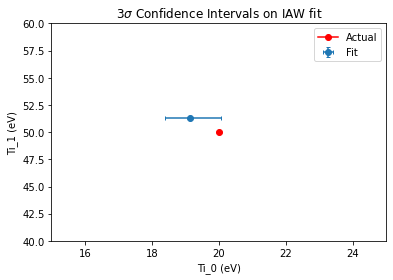

In [15]:
Ti0m3 = ci['Ti_0'][0][1]
Ti_0_fit = ci['Ti_0'][1][1]
Ti0p3 = ci['Ti_0'][2][1]

Ti1m3 = ci['Ti_1'][0][1]
Ti_1_fit = ci['Ti_1'][1][1]
Ti1p3 = ci['Ti_1'][2][1]

# Format the errorbars for input to matplotlib.errorbar
xerr = np.array([[Ti_0_fit-Ti0m3], [Ti0p3-Ti_0_fit]])
yerr  = np.array([[Ti_1_fit-Ti1m3], [Ti1p3-Ti_1_fit]])

fig, ax = plt.subplots()
ax.set_title("3$\sigma$ Confidence Intervals on IAW fit")
ax.set_xlabel("Ti_0 (eV)")
ax.set_ylabel("Ti_1 (eV)")

ax.set_xlim(15,25)
ax.set_ylim(40,60)
ax.plot(Ti[0].value, Ti[1].value, marker='o', color='red', label='Actual')
ax.errorbar(Ti_0_fit, Ti_1_fit, yerr=yerr, xerr=xerr, fmt='o', capsize=2, label='Fit')
ax.legend()

To calculate confidence intervals, use an MCMC algorithm starting at the best-fit values

In [16]:
Ti_0_fit = result.best_values['Ti_0']
Ti_1_fit = result.best_values['Ti_1']
ifract_0_fit = result.best_values['ifract_0']
ifract_1_fit = result.best_values['ifract_1']
ion_speed_1_fit = result.best_values['ion_speed_1']
print(Te_0_fit)

9.365466238598554


In [ ]:


emcee_params = Parameters()
emcee_params.add('n', value=n_fit, vary=False)
emcee_params.add('Te_0', value=Te_0_fit, vary=False)
emcee_params.add('Ti_0', value=Ti_0_fit, vary=True, min=15, max=25)
emcee_params.add('Ti_1', value=Ti_1_fit, vary=True, min=45, max=55)
emcee_params.add('ifract_0', value=ifract_0_fit, vary=False, min=0.2, max=0.8)
emcee_params.add('ifract_1', value=ifract_1_fit, vary=False, min=0.2, max=0.8, expr='1.0 - ifract_0')
emcee_params.add('ion_speed_0', value=0, vary=False)
emcee_params.add('ion_speed_1', value=ion_speed_1_fit, vary=False, min=0, max=1e6)


model = thomson.thomson_model(iaw_wavelengths, settings, emcee_params)



emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False,
             progress=True)

emcee_result = model.fit(fit_data, params=emcee_params, wavelengths=iaw_wavelengths,  method='emcee', fit_kws=emcee_kws)

 19%|█▉        | 189/1000 [09:09<36:58,  2.74s/it] 

## Re-Fitting the EPW Feature with the Full Thomson Model

Now that we have fit-estimates for the ion quantities, we can go back and fit the EPW data with the full Thomson model. 

In [34]:
emcee_result.fit_report()

"[[Model]]\n    Model(<lambda>)\n[[Fit Statistics]]\n    # fitting method   = emcee\n    # function evals   = 10000\n    # data points      = 600\n    # variables        = 3\n    chi-square         = 0.01850747\n    reduced chi-square = 3.1001e-05\n    Akaike info crit   = -6225.90634\n    Bayesian info crit = -6212.71555\n[[Variables]]\n    n:                 2.111732e+17 (fixed)\n    Te_0:              9.365466 (fixed)\n    Ti_0:              21.5975081 +/- 13.8228654 (64.00%) (init = 19.14764)\n    Ti_1:              45.4068613 +/- 16.0907844 (35.44%) (init = 51.26325)\n    ifract_0:          0.2993737 (fixed)\n    ifract_1:          0.70062630 == '1.0 - ifract_0'\n    ion_speed_0:       0 (fixed)\n    ion_speed_1:       199822.8 (fixed)\n    efract_0:          1 (fixed)\n    electron_speed_0:  0 (fixed)\n    __lnsigma:         0.00306505 +/- 0.03582477 (1168.81%) (init = 0.01)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(Ti_1, __lnsigma) =  0.496\n    C(Ti_0, Ti_1

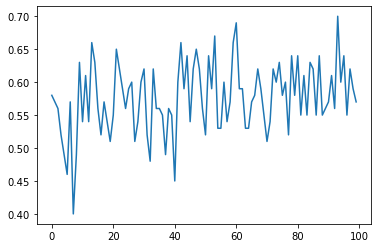

In [35]:
plt.plot(emcee_result.acceptance_fraction)

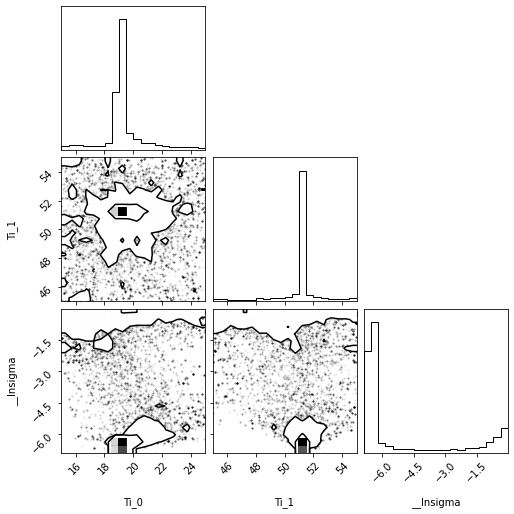

In [40]:
emcee_corner = corner.corner(emcee_result.flatchain, labels=emcee_result.var_names,
                             truths=list(emcee_result.params.valuesdict().values()))

In [43]:
emcee_result.fit_report()

"[[Model]]\n    Model(<lambda>)\n[[Fit Statistics]]\n    # fitting method   = emcee\n    # function evals   = 50000\n    # data points      = 600\n    # variables        = 3\n    chi-square         = 564.660245\n    reduced chi-square = 0.94582956\n    Akaike info crit   = -30.4232652\n    Bayesian info crit = -17.2324763\n[[Variables]]\n    n:                 2.111732e+17 (fixed)\n    Te_0:              9.365466 (fixed)\n    Ti_0:              19.1549011 +/- 0.72359116 (3.78%) (init = 19.14764)\n    Ti_1:              51.2212113 +/- 0.35894611 (0.70%) (init = 51.26325)\n    ifract_0:          0.2993737 (fixed)\n    ifract_1:          0.70062630 == '1.0 - ifract_0'\n    ion_speed_0:       0 (fixed)\n    ion_speed_1:       199822.8 (fixed)\n    efract_0:          1 (fixed)\n    electron_speed_0:  0 (fixed)\n    __lnsigma:        -6.50056043 +/- 2.63855730 (40.59%) (init = 0.01)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(Ti_1, __lnsigma) = -0.289"